##**Dataset Description**

The data provided is text data that has 6 columns with 404290 rows.

Below are the variables in our dataset:

•	id - the id of a training set question pair

•	qid1, qid2 - unique ids of each question (only available in train.csv)

•	question1, question2 - the full text of each question

•	is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.


In [ ]:
pip install contractions

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Import Libraries

import pandas as pd
import numpy as np

import re
from bs4 import BeautifulSoup
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
stop=set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.util import ngrams
from collections import  Counter

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud
colors = ['firebrick', 'tomato']

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [ ]:
# Load data

url = 'https://github.com/Koorimikiran369/Quora-Question-Pairing/raw/main/train.csv.zip'

df = pd.read_csv(url, compression='zip')
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [ ]:
df = df.drop('id', axis=1)

In [ ]:
print("Shape of the data: ", df.shape)

Shape of the data:  (404290, 5)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   qid1          404290 non-null  int64 
 1   qid2          404290 non-null  int64 
 2   question1     404289 non-null  object
 3   question2     404288 non-null  object
 4   is_duplicate  404290 non-null  int64 
dtypes: int64(3), object(2)
memory usage: 15.4+ MB


In [ ]:
# Check null values

df.isna().sum()

qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [ ]:
# Print null values

nan = df[df.isna().any(1)]
print(nan)

          qid1    qid2                         question1  \
105780  174363  174364    How can I develop android app?   
201841  303951  174364  How can I create an Android app?   
363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


qid2 has 2 null rows with the same qid

In [ ]:
# Filtering rows by question ids of nulls

target_ids = [174364,493340] 

mask_qid1 = df['qid1'].isin(target_ids)
mask_qid2 = df['qid2'].isin(target_ids)

# Filter rows based on the question IDs in either column qid1 or qid2
filtered_rows = df[mask_qid1 | mask_qid2]

print(filtered_rows)

          qid1    qid2                         question1  \
105780  174363  174364    How can I develop android app?   
201841  303951  174364  How can I create an Android app?   
363362  493340  493341                               NaN   

                                                question2  is_duplicate  
105780                                                NaN             0  
201841                                                NaN             0  
363362  My Chinese name is Haichao Yu. What English na...             0  


There are no other questions with the same question ids to replace the null values with. We can drop these rows since there are only 3 null values.

In [ ]:
# Drop rows with null values

df.dropna(inplace=True)
df.shape

(404287, 5)

In [ ]:
# Check duplicate values
 
df.duplicated().sum()

0

**Target Variable**

In [ ]:
# Target variable distribution

df['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

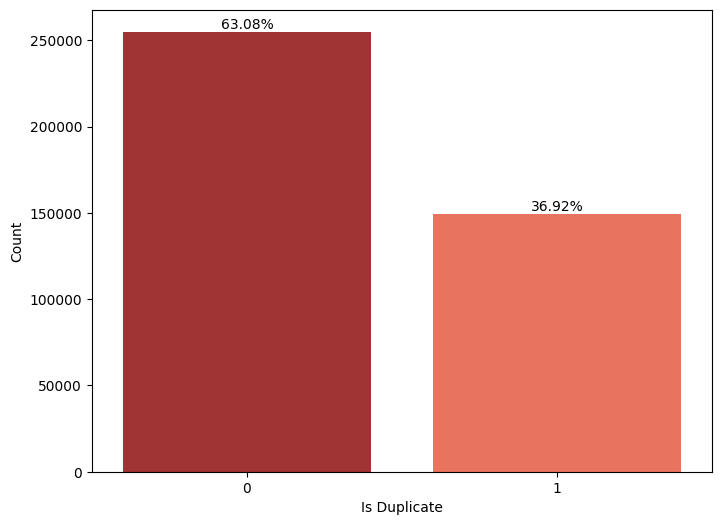

In [ ]:
# Visualizing the target distribution

plt.figure(figsize=(8, 6))
sns.countplot(x='is_duplicate', data=df, palette=colors)
plt.xlabel('Is Duplicate')
plt.ylabel('Count')

# Calculate the percentage for each category
total_count = len(df)
counts = df['is_duplicate'].value_counts()
for i, count in enumerate(counts):
    percentage = (count / total_count) * 100
    plt.text(i, count, f'{percentage:.2f}%', ha='center', va='bottom')

plt.show()

There are 63.08% non-duplicates and 36.92% duplicates indicating imbalance.

In [ ]:
# Check the number of unique questions

qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qns = len(np.unique(qids))
rep_qns = np.sum(qids.value_counts() > 1)

print ('Number of  unique Questions are: {}\n'.format(unique_qns))
print ('Number of unique questions that appear more than one time: {} ({:.2f}%)\n'.format(rep_qns, rep_qns/unique_qns*100))

Number of  unique Questions are: 537929

Number of unique questions that appear more than one time: 111778 (20.78%)



In [ ]:
# Print the top 10 most repeated questions

questions = pd.Series(df['question1'].tolist() + df['question2'].tolist())
repeated_questions = questions[qids.duplicated(keep=False)]

# Count occurrences of each question
question_counts = repeated_questions.value_counts()

# Sort questions based on occurrence count in descending order
top_10_questions = question_counts.head(10)
top_10_questions

What are the best ways to lose weight?                                                                159
How can you look at someone's private Instagram account without following them?                       120
How can I lose weight quickly?                                                                        111
What's the easiest way to make money online?                                                           88
Can you see who views your Instagram?                                                                  79
What are some things new employees should know going into their first day at AT&T?                     77
What do you think of the decision by the Indian Government to demonetize 500 and 1000 rupee notes?     68
Which is the best digital marketing course?                                                            66
How can you increase your height?                                                                      63
How do l see who viewed my videos on Instagram

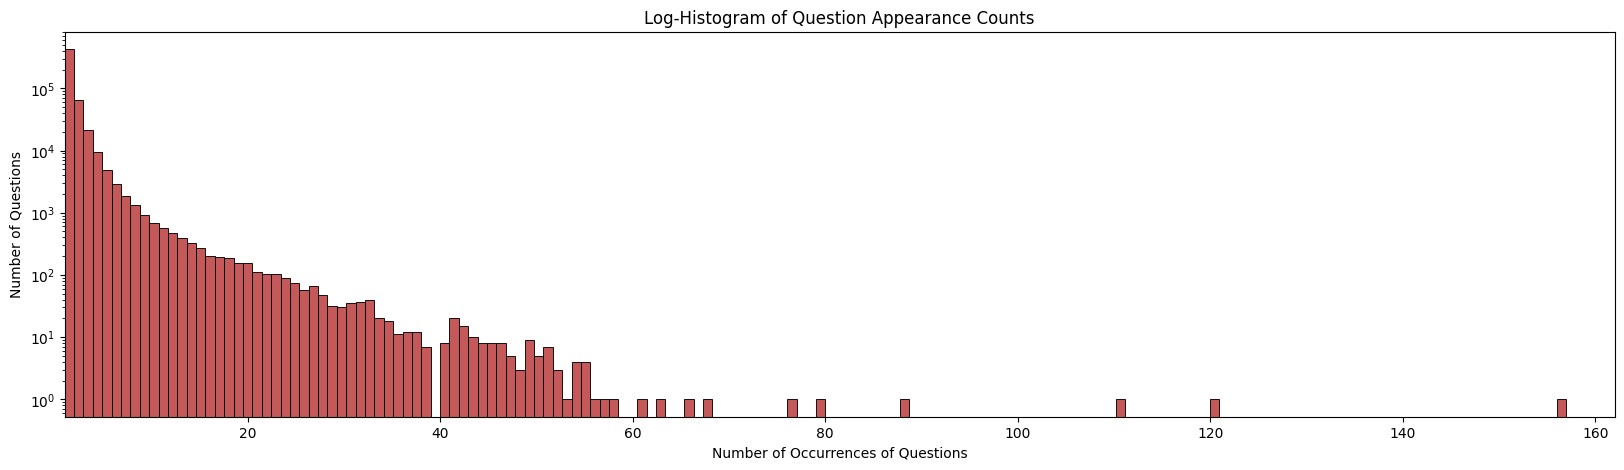

In [ ]:
# Plot the number of occurrences of questions

plt.figure(figsize=(20, 5))
sns.histplot(qids.value_counts(), bins=160,log_scale=(False, True), color = 'firebrick')
plt.xlim((1, 162))
plt.title('Log-Histogram of Question Appearance Counts')
plt.xlabel("Number of Occurrences of Questions")
plt.ylabel("Number of Questions")

plt.show()

In [ ]:
# Splitting the dataset into train and test
train_df, test_df = train_test_split(df, test_size=0.3, random_state=42, stratify= df['is_duplicate'])

# Print the shapes of the train and test DataFrames
print("Train data shape:", train_df.shape)
print("Test data shape:", test_df.shape)

Train data shape: (283000, 5)
Test data shape: (121287, 5)


## **Text Statistics**

In [ ]:
# Compute question lengths

def compute_lengths(df):
    df['question1_len'] = df['question1'].str.len()
    df['question2_len'] = df['question2'].str.len()
    df['question_len_diff'] = abs(df['question1_len'] - df['question2_len'])
    
    return df

In [ ]:
train_df = compute_lengths(train_df)
test_df = compute_lengths(test_df)

In [ ]:
# Display summary statistics

print("Summary Statistics:")
print(train_df[['question1_len', 'question2_len', 'question_len_diff']].describe())

Summary Statistics:
       question1_len  question2_len  question_len_diff
count  283000.000000  283000.000000      283000.000000
mean       59.572110      60.097318          20.148664
std        30.022655      33.894944          25.645400
min         1.000000       1.000000           0.000000
25%        39.000000      39.000000           4.000000
50%        52.000000      51.000000          12.000000
75%        72.000000      71.000000          26.000000
max       623.000000    1169.000000        1080.000000


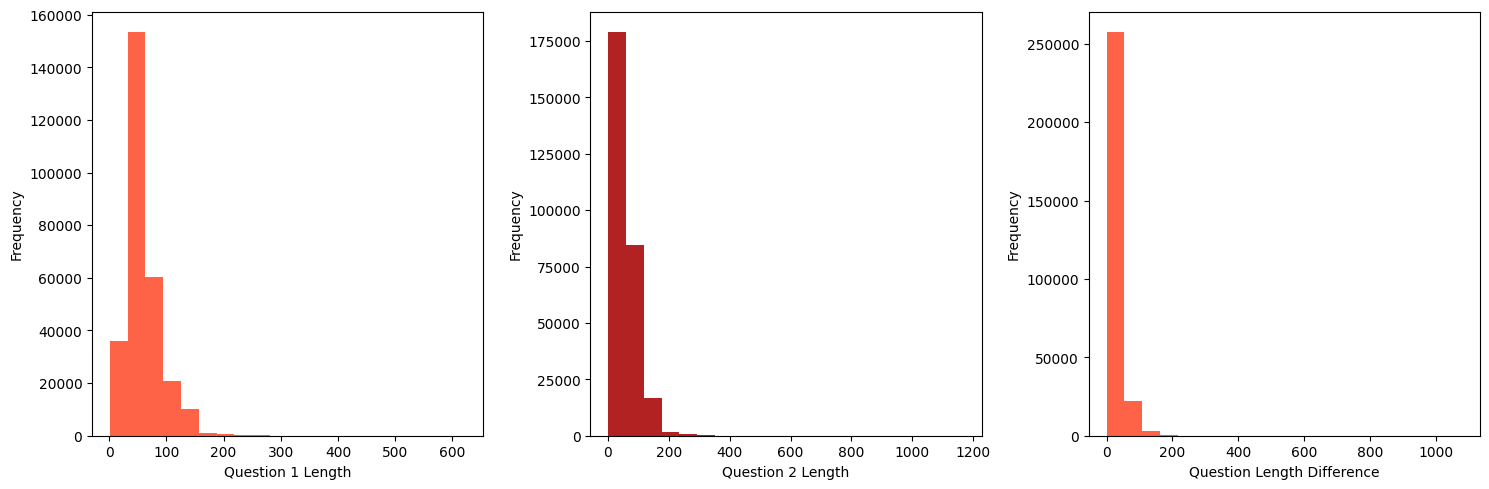

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot 'question1_len'
axes[0].hist(train_df['question1_len'], bins=20, color='tomato')
axes[0].set_xlabel('Question 1 Length')
axes[0].set_ylabel('Frequency')

# Plot 'question2_len'
axes[1].hist(train_df['question2_len'], bins=20, color='firebrick')
axes[1].set_xlabel('Question 2 Length')
axes[1].set_ylabel('Frequency')

# Plot 'question_len_diff'
axes[2].hist(train_df['question_len_diff'], bins=20, color='tomato')
axes[2].set_xlabel('Question Length Difference')
axes[2].set_ylabel('Frequency')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

In [ ]:
# Printing one word rows

one_len_rows = train_df[(train_df['question1_len'] == 1) | (train_df['question2_len'] == 1)]

print(len(one_len_rows))
one_len_rows

18


,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question_len_diff
96725,161071,161072,?,"Who are Moses, Noah and Exodus?",0,1,31,30
13016,25026,25027,?,Why should one not work at Google?,0,1,34,33
104101,171925,171926,?,"Problem of solving a problem is not a problem,...",0,1,149,148
190570,289688,289689,‘,"Time is money.Can some one explain, how it works?",0,1,49,48
108978,178936,178937,i,What questions to ask any drdummer?,0,1,35,34
158778,247989,48850,A,Do men forgive their wives when they cheat on ...,0,1,51,50
198913,300250,188110,What is this?,o,0,13,1,12
151922,188110,238787,o,What is this - “This website/URL has been bloc...,0,1,132,131
47056,84067,84068,Is there anywhere in the world offering pain m...,?,0,117,1,116
20794,39204,39205,?,What is the Gmail tech support help phone number?,0,1,49,48


The rows with length 1 comprise of letters and special characters. These rows will not be helpful for the question similarity problem.

In [ ]:
# Drop the rows with one-word questions

train_df = train_df.drop(one_len_rows.index)
train_df.shape

(282982, 8)

In [ ]:
# Same treatment for test_df

one_len_rows = test_df[(test_df['question1_len'] == 1) | (test_df['question2_len'] == 1)]

print(len(one_len_rows))
one_len_rows

3


,qid1,qid2,question1,question2,is_duplicate,question1_len,question2_len,question_len_diff
213220,25026,64784,?,What is it like to work at Google?,0,1,34,33
3306,6553,6554,.,Why is Cornell's endowment the lowest in the I...,0,1,56,55
357127,486520,146954,H,Should I forgive the cheater?,0,1,29,28


In [ ]:
test_df = test_df.drop(one_len_rows.index)
test_df.shape

(121284, 8)

**Average word length in a question**

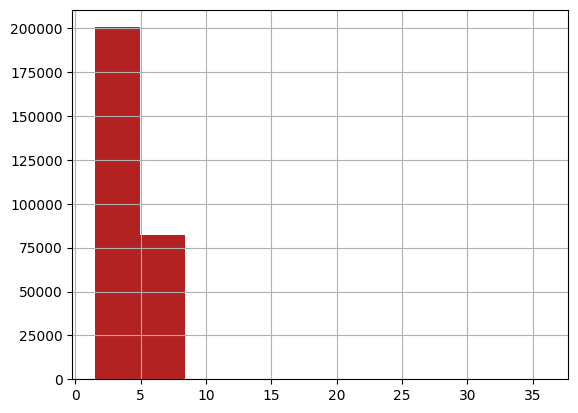

In [ ]:
# Train

train_df['question1'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(color = 'firebrick');

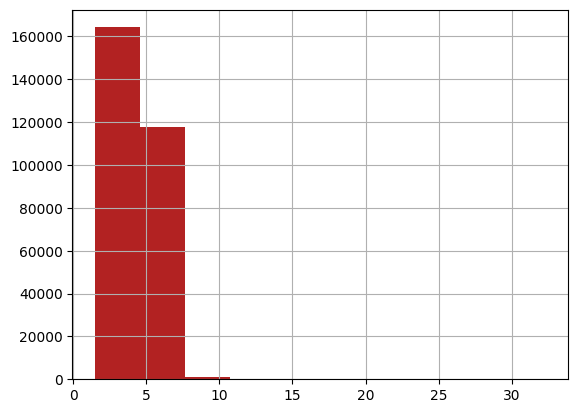

In [ ]:
train_df['question2'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(color = 'firebrick');

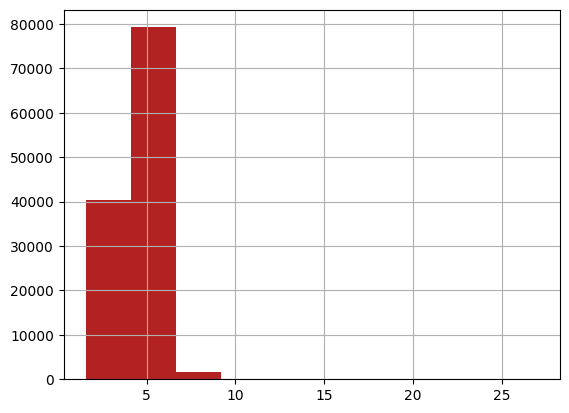

In [ ]:
test_df['question2'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(color = 'firebrick');

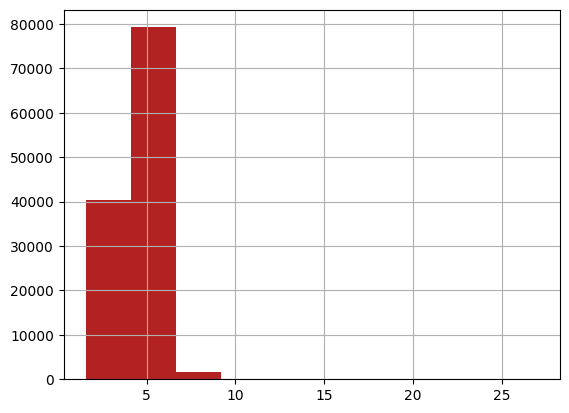

In [ ]:
test_df['question2'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x)).hist(color = 'firebrick');

**Word Cloud**

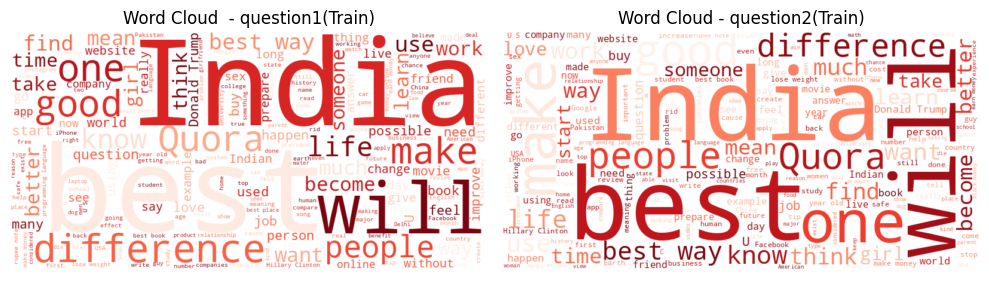

In [ ]:
# Generate world clouds for 'question1' and 'question2' for the train dataset 
question1_text = ' '.join(train_df['question1'])
question2_text = ' '.join(train_df['question2'])

wordcloud1 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(question1_text)
wordcloud2 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(question2_text)

# Plot word clouds
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Word Cloud  - question1(Train)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Word Cloud - question2(Train)')
plt.axis('off')

plt.tight_layout()
plt.show()

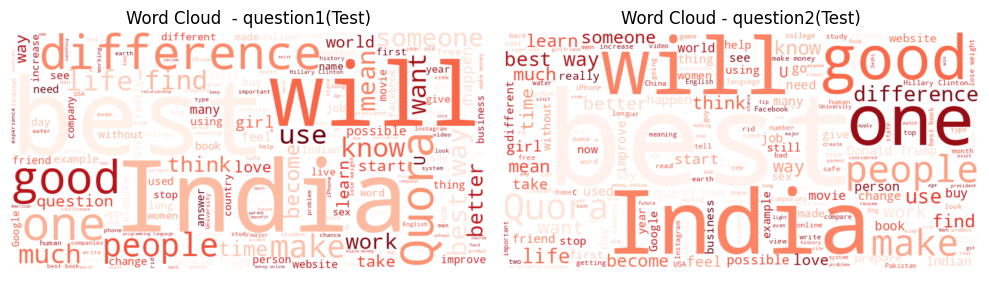

In [ ]:
# Generate world clouds for 'question1' and 'question2' for the test dataset 
question1_text = ' '.join(test_df['question1'])
question2_text = ' '.join(test_df['question2'])

wordcloud1 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(question1_text)
wordcloud2 = WordCloud(width=800, height=400, background_color='white', colormap='Reds').generate(question2_text)

# Plot word clouds
plt.figure(figsize=(10, 6))
plt.subplot(1, 2, 1)
plt.imshow(wordcloud1, interpolation='bilinear')
plt.title('Word Cloud  - question1(Test)')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(wordcloud2, interpolation='bilinear')
plt.title('Word Cloud - question2(Test)')
plt.axis('off')

plt.tight_layout()
plt.show()

**Top n-grams**

In [ ]:
def plot_top_ngrams_barchart(text, n=2):
  
    new= text.str.split()
    new=new.values.tolist()
    corpus=[word for i in new for word in i]

    def _get_top_ngram(corpus, n=None):
        vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
        bag_of_words = vec.transform(corpus)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) 
                      for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:10]

    top_n_bigrams=_get_top_ngram(text,n)[:10]
    x,y=map(list,zip(*top_n_bigrams))
    sns.barplot(x=y,y=x)

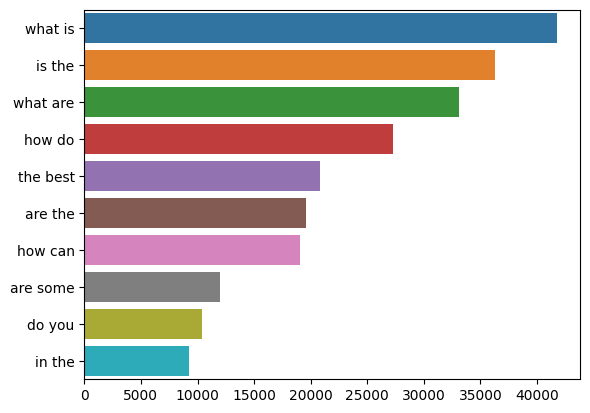

In [ ]:
plot_top_ngrams_barchart(train_df['question1'],2)

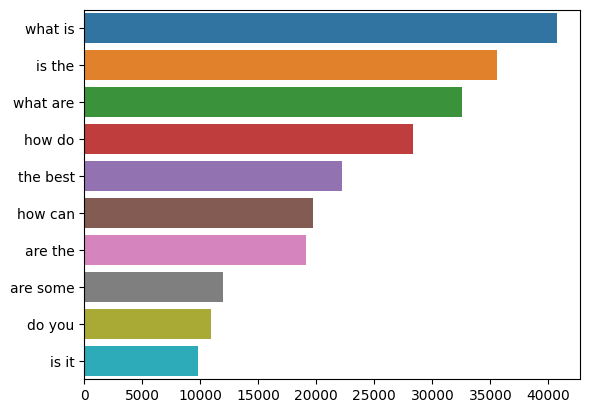

In [ ]:
plot_top_ngrams_barchart(train_df['question2'],2)

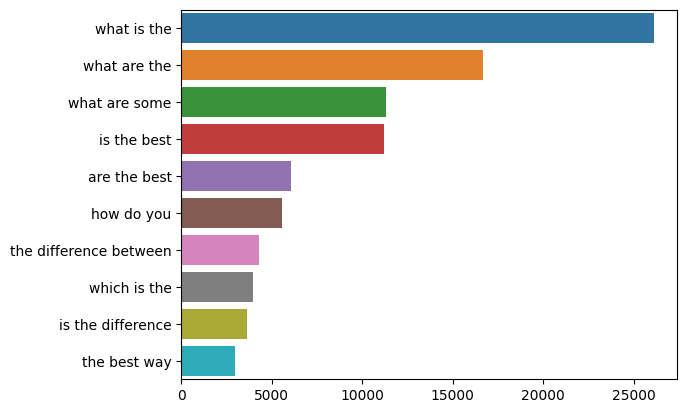

In [ ]:
plot_top_ngrams_barchart(train_df['question1'],3)

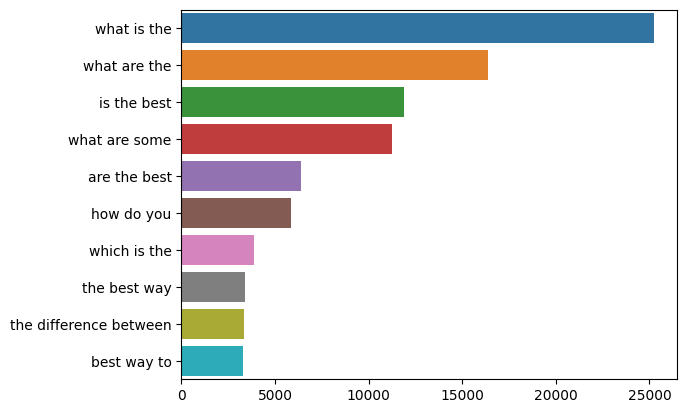

In [ ]:
plot_top_ngrams_barchart(train_df['question2'],3)